**Note: One shouldn't make trades with any models developed in this project. Trading stocks has risks, and nothing in this project constitutes stock trading advice.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# 0. Introduction

In this mission, we'll be working with a csv file containing index prices. Each row in the file contains a daily record of the price of the S&P500 Index from 1950 to 2015. The dataset is stored in sphist.csv.

The columns of the dataset are:

    Date -- The date of the record.
    Open -- The opening price of the day (when trading starts).
    High -- The highest trade price during the day.
    Low -- The lowest trade price during the day.
    Close -- The closing price for the day (when trading is finished).
    Volume -- The number of shares traded.
    Adj Close -- The daily closing price, adjusted retroactively to include any corporate actions. Read more here.

We'll be using this dataset to develop a predictive model. We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

# 1. Reading in the data

In [2]:
sp500 = pd.read_csv("sphist.csv")
sp500.Date = pd.to_datetime(sp500.Date)
sp500.sort_values("Date", inplace=True)

In [3]:
sp500.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


# 2. Generating indicators

Datasets taken from the stock market need to be handled differently than datasets from other sectors when it comes time to make predictions. In a normal machine learning exercise, we treat each row as independent. Stock market data is sequential, and each observation comes a day after the previous observation. Thus, the observations are not all independent, and you can't treat them as such.

For this reason, we will create Moving Average indicators on the closing price for a period of 5 days (MAP5), 30 days (MAP30) and 365 days (MAP365).

"Day" means "trading days", so we don't count weekends or holiday.

In [4]:
def moving_average_price(period):
    return sp500.Close.rolling(period).mean().shift(1)

sp500["MAP5"] = moving_average_price(5)
sp500["MAP30"] = moving_average_price(30)
sp500["MAP365"] = moving_average_price(365)
sp500.head(40)

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
16589,1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000.0,16.660000,NaN,NaN,NaN
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000.0,16.850000,NaN,NaN,NaN
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000.0,16.930000,NaN,NaN,NaN
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000.0,16.980000,NaN,NaN,NaN
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000.0,17.080000,NaN,NaN,NaN
16584,1950-01-10,17.030001,17.030001,17.030001,17.030001,2160000.0,17.030001,16.900,NaN,NaN
16583,1950-01-11,17.090000,17.090000,17.090000,17.090000,2630000.0,17.090000,16.974,NaN,NaN
16582,1950-01-12,16.760000,16.760000,16.760000,16.760000,2970000.0,16.760000,17.022,NaN,NaN
16581,1950-01-13,16.670000,16.670000,16.670000,16.670000,3330000.0,16.670000,16.988,NaN,NaN
16580,1950-01-16,16.719999,16.719999,16.719999,16.719999,1460000.0,16.719999,16.926,NaN,NaN


# 3. Splitting up the data

Since you're computing indicators that use historical data, there are some rows where there isn't enough historical data to generate them. Some of the indicators use 365 days of historical data, and the dataset starts on 1950-01-03. Thus, any rows that are 365 "days" before 1951-01-03 don't have enough historical data to compute all the indicators. You'll need to remove these rows before you split the data.

In [5]:
sp500.dropna(inplace=True)
sp500.head(10)

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082
16219,1951-06-26,21.299999,21.299999,21.299999,21.299999,1260000.0,21.299999,21.710,21.564333,19.513617
16218,1951-06-27,21.370001,21.370001,21.370001,21.370001,1360000.0,21.370001,21.566,21.535000,19.525315
16217,1951-06-28,21.100000,21.100000,21.100000,21.100000,1940000.0,21.100000,21.458,21.522000,19.537041
16216,1951-06-29,20.959999,20.959999,20.959999,20.959999,1730000.0,20.959999,21.322,21.502333,19.548932
16215,1951-07-02,21.100000,21.100000,21.100000,21.100000,1350000.0,21.100000,21.204,21.470667,19.560685


We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.

In [6]:
date_filter = sp500["Date"] > datetime(year=2013, month=1, day=1)
train = sp500[~date_filter]
test = sp500[date_filter]

In [7]:
train.head()

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
16224,1951-06-19,22.020000,22.020000,22.020000,22.020000,1100000.0,22.020000,21.800,21.703333,19.447726
16223,1951-06-20,21.910000,21.910000,21.910000,21.910000,1120000.0,21.910000,21.900,21.683000,19.462411
16222,1951-06-21,21.780001,21.780001,21.780001,21.780001,1100000.0,21.780001,21.972,21.659667,19.476274
16221,1951-06-22,21.549999,21.549999,21.549999,21.549999,1340000.0,21.549999,21.960,21.631000,19.489562
16220,1951-06-25,21.290001,21.290001,21.290001,21.290001,2440000.0,21.290001,21.862,21.599000,19.502082


In [8]:
train.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
743,2012-12-24,1430.150024,1430.150024,1424.660034,1426.660034,1.248960e+09,1426.660034,1437.360010,1405.926001,1326.114028
742,2012-12-26,1426.660034,1429.420044,1416.430054,1419.829956,2.285030e+09,1419.829956,1436.620019,1407.486336,1326.412494
741,2012-12-27,1419.829956,1422.800049,1401.800049,1418.099976,2.830180e+09,1418.099976,1431.228003,1408.813000,1326.716494
740,2012-12-28,1418.099976,1418.099976,1401.579956,1402.430054,2.426680e+09,1402.430054,1427.685986,1410.265332,1326.995836
739,2012-12-31,1402.430054,1426.739990,1398.109985,1426.189941,3.204330e+09,1426.189941,1419.434009,1411.830001,1327.261562


In [9]:
test.head()

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
738,2013-01-02,1426.189941,1462.430054,1426.189941,1462.420044,4.202600e+09,1462.420044,1418.641992,1414.258667,1327.534055
737,2013-01-03,1462.420044,1465.469971,1455.530029,1459.369995,3.829730e+09,1459.369995,1425.793994,1417.676668,1327.908247
736,2013-01-04,1459.369995,1467.939941,1458.989990,1466.469971,3.424290e+09,1466.469971,1433.702002,1420.092668,1328.224877
735,2013-01-07,1466.469971,1466.469971,1456.619995,1461.890015,3.304970e+09,1461.890015,1443.376001,1422.714665,1328.557617
734,2013-01-08,1461.890015,1461.890015,1451.640015,1457.150024,3.601600e+09,1457.150024,1455.267993,1425.076664,1328.898603


In [10]:
test.tail()

,Date,Open,High,Low,Close,Volume,Adj Close,MAP5,MAP30,MAP365
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883,2087.024023,2073.984998,2035.531178
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010,2090.231982,2076.283993,2035.914082
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117,2088.306006,2077.908659,2036.234356
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941,2080.456006,2078.931331,2036.507343
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068,2080.771973,2080.237329,2036.869425


# 4. Making predictions

In [11]:
features = ["MAP5", "MAP30", "MAP365"]
target = ["Close"]
model = LinearRegression()
model.fit(train[features], train[target])
closePricePrediction = model.predict(test[features])
mae = mean_absolute_error(closePricePrediction, test[target])
rmse = mean_squared_error(closePricePrediction, test[target])**0.5

In [12]:
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

Mean Absolute Error:  16.142439643554408
Root Mean Square Error:  22.22006532421962


In [13]:
sp500.Close.describe()

count    16225.000000
mean       493.113714
std        556.800880
min         20.959999
25%         86.529999
50%        159.880005
75%        977.590027
max       2130.820068
Name: Close, dtype: float64

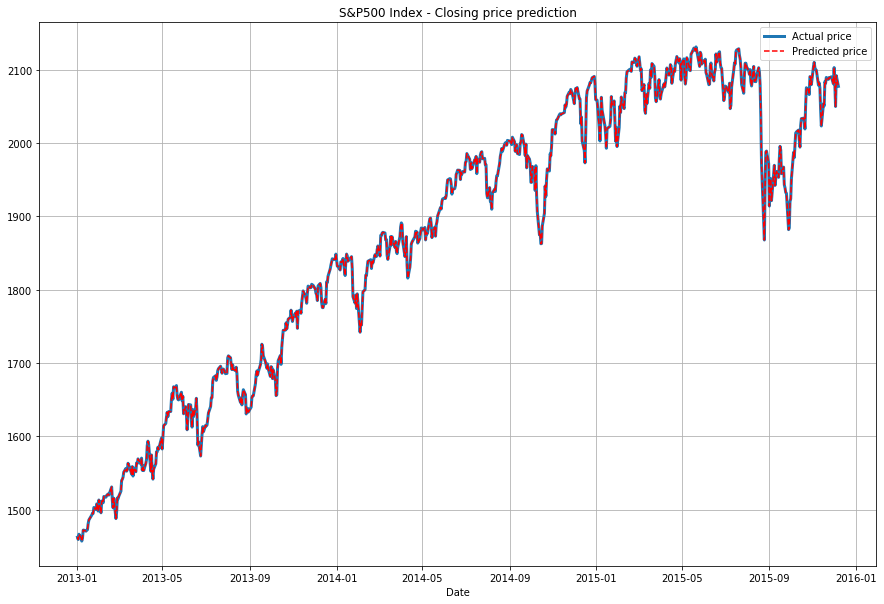

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(test.Date, test.Close, label="Actual price", lw = 3)
plt.plot(test.Date, test.Close, '--', c='red', label="Predicted price")
plt.title("S&P500 Index - Closing price prediction")
plt.xlabel("Date")
plt.legend()
plt.grid()
plt.show()

# 5. Conclusion

Our model gives the prediction very close to the actual price.